# Data Loading

Note that we will encode a positive review as a 1 and a negative review as a 0.

In [1]:
import os
import pandas as pd
import string
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

In [2]:
TRAIN_PATH = 'aclImdb/train'
TEST_PATH = 'aclImdb/test'

In [3]:
def data_read(path, train_or_test, pos_or_neg):
    reviews, labels = [], []
    
    for filename in os.listdir(path + '/' + pos_or_neg):
        with open(path + '/' + pos_or_neg + '/' + filename) as f:
            reviews.append(f.read())
        if pos_or_neg == 'pos':
            label = 1
        else:
            label = 0
        labels.append(label)
    
    return reviews, labels

In [4]:
pos_results = data_read(TRAIN_PATH, 'train', 'pos')
reviews = pos_results[0]
labels = pos_results[1]

neg_results = data_read(TRAIN_PATH, 'train', 'neg')
reviews += neg_results[0]
labels += neg_results[1]

In [5]:
train_df = pd.DataFrame({'reviews': reviews, 'y': labels})

In [6]:
train_df.head()

,reviews,y
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1


In [7]:
pos_results = data_read(TRAIN_PATH, 'test', 'pos')
reviews = pos_results[0]
labels = pos_results[1]

neg_results = data_read(TRAIN_PATH, 'test', 'neg')
reviews += neg_results[0]
labels += neg_results[1]

In [8]:
test_df = pd.DataFrame({'reviews': reviews, 'y': labels})

In [9]:
test_df.head()

,reviews,y
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1


In [10]:
test_df.tail()

,reviews,y
24995,"My comments may be a bit of a spoiler, for wha...",0
24996,"The ""saucy"" misadventures of four au pairs who...",0
24997,"Oh, those Italians! Assuming that movies about...",0
24998,Eight academy nominations? It's beyond belief....,0
24999,"Not that I dislike childrens movies, but this ...",0


# Pre-Processing

In [11]:
train_df['reviews'] = [msg.lower() for msg in train_df['reviews']]
train_df['reviews'] = [s.translate(str.maketrans('', '', string.punctuation)) for s in train_df['reviews']]
train_df['reviews'] = [' '.join([ps.stem(w) for w in msg.split()]) for msg in train_df['reviews']]

In [12]:
test_df['reviews'] = [msg.lower() for msg in test_df['reviews']]
test_df['reviews'] = [s.translate(str.maketrans('', '', string.punctuation)) for s in test_df['reviews']]
test_df['reviews'] = [' '.join([ps.stem(w) for w in msg.split()]) for msg in test_df['reviews']]

In [13]:
MAX_LENGTH = 15

UNK_token = 0
PAD_token = 1
SOS_token = 2
EOS_token = 3

In [14]:
class Voc(Dataset):
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: 'PAD', SOS_token: 'SOS', 
                           EOS_token: 'EOS', UNK_token: 'UNK'}
        self.num_words = 4 # include the ones above

    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word.lower())

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # remove words that appear less frequently
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True
        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: 'PAD', SOS_token: 'SOS', 
                           EOS_token: 'EOS', UNK_token: 'UNK'}
        self.num_words = 4
        for word in keep_words:
            self.add_word(word)

# takes string sentence and returns sentence of word indices
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split()] + [EOS_token]

In [15]:
class ReviewDataset():
    def __init__(self, df):
        """Bad coding practice to use the globals but it will work for now"""
        self.reviews = df
        self.text = df['reviews']
        self.rating = df['y']
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        return (self.text[idx], self.rating[idx])

In [16]:
reviews = Voc('reviews')

In [17]:
for review in train_df['reviews']:
    reviews.add_sentence(review)

In [18]:
train_ds = ReviewDataset(train_df)
test_ds = ReviewDataset(test_df)

In [19]:
indexesFromSentence(reviews, 'hello world')

[1161, 493, 3]

Write out reviews to pickle object for later prediction

In [20]:
import pickle

pickle.dump(reviews, open('./model/reviews.pkl', 'wb'))

In [21]:
train_dataloader = DataLoader(train_ds,
                              batch_size=1000,
                              shuffle=True, 
                              num_workers=4)

test_dataloader = DataLoader(test_ds,
                             batch_size=1000,
                             shuffle=True,
                             num_workers=4)

# Modeling

The Han model is going to fit a GRU, and for each word i in the sequence, we will collect the hidden layer $h_{i}$. Then for the attention model we have the following algorithm, for word $w_{t}$ in sentence of length T.

$$u_{t} = tanh(W_{w}h_{t} + b_{w})$$

$$\alpha_{t} = \frac{exp(u_{t}^{T}u_{w})}{\Sigma_{t}exp(u_{t}^{T}u_{w})}$$

$$s = \Sigma_{t} \alpha_{t}h_{t}$$

s is then input into a neural network for regression or classification.

In [22]:
class HAN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=60, hidden_size=15, num_layers=1, dropout=0.1):
        super(HAN, self).__init__()
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True,
                              dropout=(0 if num_layers==1 else dropout),
                              bidirectional=True)

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(2*hidden_size, 100)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(100, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)
        self.fc3 = nn.Linear(2*hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_seq, input_lengths, hidden=None):
        # convert word indices to embeddings
        embedded = self.embedding(input_seq)
        
        # pass embeddings through GRU
        # all_layers is shape batch_size x max(sentence_length) x hidden_size*2
        all_layers, final = self.gru(embedded, hidden)

        # pass the hidden layers through linear layer
        # each word of each document will now be a length 100 tensor
        u = self.tanh( self.fc1(all_layers) )
        
        # map the length 100 tensor to a scalar representing importance
        # take the softmax to get the word importance WRT the document
        alpha = self.softmax( self.fc2(u) )
        
        # take sum of hidden layers for each sentence weighted by the alphas 
        s = (all_layers*alpha).sum(dim=1)
        
        # take the linear combination of hidden layers and 
        # plug into Linear Layer and Sigmoid to get probability
        s = self.sigmoid( self.fc3(s) )
        
        return s.squeeze(), alpha.squeeze() # will add alphas for visualization later

In [23]:
def train(model, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        losses = []
        
        for i, mails in enumerate(train_dataloader):
            # read in values from dataloader
            x = mails[0]
            y = mails[1]

            # index sentence and get lengths
            x = [sen.split() for sen in x]
            lengths = [len(sen) for sen in x]
            x = [[reviews.word2index.get(word, UNK_token) for word in sentence] for sentence in x]

            # create padded matrix
            batch_size = len(y)
            max_length = max(lengths)
            padded_x = np.ones((batch_size, max_length))*PAD_token
            for idx, x_len in enumerate(lengths):
                sequence = x[idx]
                padded_x[idx, 0:x_len] = sequence[:x_len]

            x = torch.Tensor(padded_x).long()
            y_hat, alpha = han(x, lengths)
            optimizer.zero_grad()
            
            loss = criterion(y_hat, y.float())
            loss.backward()
            optimizer.step()
            losses += [loss.item()]
            
        print(f'Train Loss after {epoch+1} epochs: {np.mean(losses)}')
        if epoch % 5 == 4:
            test(model)


def test(model):
    model.eval()
    losses, correct, total = [], 0, 0
    for i, mails in enumerate(test_dataloader):
        # read in values from dataloader
        x = mails[0]
        y = mails[1]

        # index sentence and get lengths
        x = [sen.split() for sen in x]
        lengths = [len(sen) for sen in x]
        x = [[reviews.word2index.get(word, UNK_token) for word in sentence] for sentence in x]

        # create padded matrix
        batch_size = len(y)
        max_length = max(lengths)
        
        padded_x = np.ones((batch_size, max_length))*PAD_token
        for idx, x_len in enumerate(lengths):
            sequence = x[idx]
            padded_x[idx, 0:x_len] = sequence[:x_len]

        x = torch.Tensor(padded_x).long()
        y_hat, _ = han(x, lengths)

        # cross-entropy
        loss = criterion(y_hat, y.float())
        losses += [loss.item()]
        
        # accuracy
        # print(y_hat == y)
        # correct += sum( y_hat == y )
        # total += y.shape.squeeze().tolist()
        
    print(f'Test Loss: {np.mean(losses)}\n')
    # print(f'Test Accuracy: {correct / total}')

# Training

In [24]:
3V = len(reviews.index2word)
han = HAN(hidden_size=40, vocab_size=V, embedding_dim=50)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(han.parameters(), lr=0.01)

train(han, 20)

Train Loss after 1 epochs: 0.6950127649307251
Train Loss after 2 epochs: 0.6808984565734864
Train Loss after 3 epochs: 0.6182800579071045
Train Loss after 4 epochs: 0.5813623476028442
Train Loss after 5 epochs: 0.5632908606529236
Test Loss: 0.5549108505249023

Train Loss after 6 epochs: 0.5505723786354065
Train Loss after 7 epochs: 0.5451652956008911
Train Loss after 8 epochs: 0.5390304303169251
Train Loss after 9 epochs: 0.5345871043205261
Train Loss after 10 epochs: 0.5307740354537964
Test Loss: 0.5264209222793579

Train Loss after 11 epochs: 0.5287617301940918
Train Loss after 12 epochs: 0.524873719215393
Train Loss after 13 epochs: 0.5228457617759704
Train Loss after 14 epochs: 0.5233321905136108
Train Loss after 15 epochs: 0.5254122829437256
Test Loss: 0.5217818689346313

Train Loss after 16 epochs: 0.522824981212616
Train Loss after 17 epochs: 0.5209297347068786
Train Loss after 18 epochs: 0.5194813179969787
Train Loss after 19 epochs: 0.51853999376297
Train Loss after 20 epochs:

In [25]:
torch.save(han.state_dict(), '/Users/jon_ross/Desktop/HAN_clean.pt')

#### Resume here by loading the model

In [23]:
V = len(reviews.index2word)
han = HAN(hidden_size=40, vocab_size=V, embedding_dim=50)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(han.parameters(), lr=0.01)

han.load_state_dict(torch.load('/Users/jon_ross/sideProj/website/model/HAN_lower.pt'))
han.eval()

HAN(
  (gru): GRU(50, 40, batch_first=True, bidirectional=True)
  (embedding): Embedding(251641, 50)
  (fc1): Linear(in_features=80, out_features=100, bias=True)
  (tanh): Tanh()
  (fc2): Linear(in_features=100, out_features=1, bias=False)
  (softmax): Softmax()
  (fc3): Linear(in_features=80, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [23]:
train(han, 10)

Train Loss after 1 epochs: 0.5214558720588685
Train Loss after 2 epochs: 0.5156813716888428
Train Loss after 3 epochs: 0.514751056432724
Train Loss after 4 epochs: 0.5144688582420349
Train Loss after 5 epochs: 0.5147349214553834
Test Loss: 0.5148994946479797

Train Loss after 6 epochs: 0.5157215976715088
Train Loss after 7 epochs: 0.5156684958934784
Train Loss after 8 epochs: 0.5150830388069153
Train Loss after 9 epochs: 0.5154467701911927
Train Loss after 10 epochs: 0.5136247301101684
Test Loss: 0.5127641570568084



In [24]:
train(han, 10)

Train Loss after 1 epochs: 0.5129567635059357
Train Loss after 2 epochs: 0.512871778011322
Train Loss after 3 epochs: 0.5124013948440552
Train Loss after 4 epochs: 0.5126206040382385
Train Loss after 5 epochs: 0.512900333404541
Test Loss: 0.5128588724136353

Train Loss after 6 epochs: 0.512196718454361
Train Loss after 7 epochs: 0.512180050611496
Train Loss after 8 epochs: 0.5134016942977905
Train Loss after 9 epochs: 0.5119988882541656
Train Loss after 10 epochs: 0.5118386626243592
Test Loss: 0.5111083388328552



In [25]:
train(han, 10)

Train Loss after 1 epochs: 0.5113566875457763
Train Loss after 2 epochs: 0.5108390665054321
Train Loss after 3 epochs: 0.5110727632045746
Train Loss after 4 epochs: 0.5109731912612915
Train Loss after 5 epochs: 0.5106906700134277
Test Loss: 0.5103581595420837

Train Loss after 6 epochs: 0.5105051362514496
Train Loss after 7 epochs: 0.5103676033020019
Train Loss after 8 epochs: 0.5101380777359009
Train Loss after 9 epochs: 0.5100115621089936
Train Loss after 10 epochs: 0.5100088846683503
Test Loss: 0.5098927581310272



In [26]:
train(han, 10)

Train Loss after 1 epochs: 0.5100021982192993
Train Loss after 2 epochs: 0.5100687432289124
Train Loss after 3 epochs: 0.5098020458221435
Train Loss after 4 epochs: 0.5097366654872895
Train Loss after 5 epochs: 0.5096450424194336
Test Loss: 0.5096076893806457

Train Loss after 6 epochs: 0.5096347463130951
Train Loss after 7 epochs: 0.5096398425102234
Train Loss after 8 epochs: 0.5097169744968414
Train Loss after 9 epochs: 0.5099311256408692
Train Loss after 10 epochs: 0.5104057645797729
Test Loss: 0.5098689675331116



In [23]:
train(han, 20)

Train Loss after 1 epochs: 0.5106182849407196
Train Loss after 2 epochs: 0.5109199261665345
Train Loss after 3 epochs: 0.5100345838069916
Train Loss after 4 epochs: 0.5095074379444122
Train Loss after 5 epochs: 0.5095135581493377
Test Loss: 0.5092803609371185

Train Loss after 6 epochs: 0.5093630003929138
Train Loss after 7 epochs: 0.5092614543437958
Train Loss after 8 epochs: 0.5091621339321136
Train Loss after 9 epochs: 0.5092394518852233
Train Loss after 10 epochs: 0.5098104321956635
Test Loss: 0.5089573621749878

Train Loss after 11 epochs: 0.5090854740142823
Train Loss after 12 epochs: 0.5092040395736694
Train Loss after 13 epochs: 0.5090126204490661
Train Loss after 14 epochs: 0.5087879073619842
Train Loss after 15 epochs: 0.5083959913253784
Test Loss: 0.5081046855449677

Train Loss after 16 epochs: 0.5083082234859466
Train Loss after 17 epochs: 0.5081970369815827
Train Loss after 18 epochs: 0.5079572975635529
Train Loss after 19 epochs: 0.5079389655590058
Train Loss after 20 epo

In [24]:
train(han, 10)

Train Loss after 1 epochs: 0.507928593158722
Train Loss after 2 epochs: 0.5085471534729004
Train Loss after 3 epochs: 0.5081615054607391
Train Loss after 4 epochs: 0.5079267120361328
Train Loss after 5 epochs: 0.5077857565879822
Test Loss: 0.5076735424995422

Train Loss after 6 epochs: 0.50793212890625
Train Loss after 7 epochs: 0.5078068602085114
Train Loss after 8 epochs: 0.5076055216789246
Train Loss after 9 epochs: 0.507716772556305
Train Loss after 10 epochs: 0.5075769853591919
Test Loss: 0.5078012835979462



In [24]:
train(han, 20)

Train Loss after 1 epochs: 0.5077660274505615
Train Loss after 2 epochs: 0.5077108120918274
Train Loss after 3 epochs: 0.5076938283443451
Train Loss after 4 epochs: 0.508044751882553
Train Loss after 5 epochs: 0.5074990367889405
Test Loss: 0.5074690568447113

Train Loss after 6 epochs: 0.507408915758133
Train Loss after 7 epochs: 0.507298446893692
Train Loss after 8 epochs: 0.5072609877586365
Train Loss after 9 epochs: 0.5072231805324554
Train Loss after 10 epochs: 0.5071840131282807
Test Loss: 0.5071391451358795

Train Loss after 11 epochs: 0.5071390974521637
Train Loss after 12 epochs: 0.5071385967731475
Train Loss after 13 epochs: 0.5071383833885192
Train Loss after 14 epochs: 0.5071383047103882
Train Loss after 15 epochs: 0.5071383035182953
Test Loss: 0.5071379935741425

Train Loss after 16 epochs: 0.5071378803253174
Train Loss after 17 epochs: 0.5071383500099182
Train Loss after 18 epochs: 0.5071239829063415
Train Loss after 19 epochs: 0.5071846306324005
Train Loss after 20 epochs

In [25]:
torch.save(han.state_dict(), '/Users/jon_ross/Desktop/HAN_lower.pt')

# Visualize Attention

In [43]:
import matplotlib.pyplot as plt
from matplotlib import transforms

def text_color(x, y, strings, colors, ax=None, **kw): 
    """x and y will be equal to 0
    strings is a list of words
    colors is a list of numbers [0,1] 
    where 1 represents the most important word"""
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    canvas = ax.figure.canvas

    # horizontal version
    for s, c in zip(strings, colors):
        text = ax.text(x, y, s + " ", color=(0.69-0.69*c,0.69-0.69*c,1), transform=t, **kw)
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(
            text.get_transform(), x=ex.width, units='dots')
        

def visualize_attention(sentence):
    sentence_tensor = torch.Tensor( [reviews.word2index[word] for word in sentence.split()] ).long()
    sentence_tensor = sentence_tensor.unsqueeze(dim=0)
    
    p, alpha = han( sentence_tensor, [len(sentence.split())] )
    print(f'Probability of positive review: {p}')
    
    text_color(0, 0, sentence.split(), alpha.tolist())
    plt.axis('off')

TODO: Unseen words are breaking the visualize function and I think it's because of the casing issues

Probability of positive review: 0.0004007560492027551


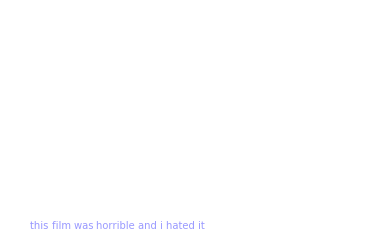

In [28]:
visualize_attention('this film was horrible and i hated it')

Probability of positive review: 0.9995682835578918


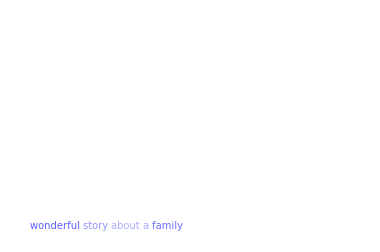

In [30]:
visualize_attention('wonderful story about a family')

Probability of positive review: 0.9996213912963867


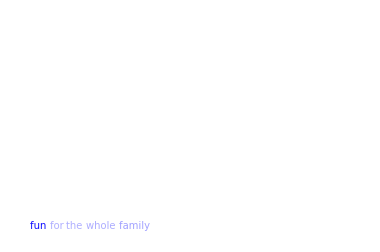

In [32]:
visualize_attention('fun for the whole family')